This modifies 2d-small.ipynb to use a 10d latent space; we see it isn't nontrivial. 

In [8]:
import torch
import torchvision
import torch.nn as nn
import numpy as np
import scipy.stats
import pandas as pd
import matplotlib.pyplot as plt
import torch.distributions as td
from torch import optim
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.linear_model import BayesianRidge
from sklearn.impute import IterativeImputer, SimpleImputer
from torchvision.datasets import MNIST
from torchvision import transforms
import matplotlib as mpl
import matplotlib.colors as mcolors
from sklearn.decomposition import PCA

def set_plt_layout():
    mpl.style.use('seaborn-v0_8-bright')
    mpl.rcParams['pdf.fonttype'] = 42
    mpl.rcParams['ps.fonttype'] = 42
    mpl.rcParams['text.usetex'] = False
    plt.rcParams.update({
        'axes.labelsize': 20,
        'xtick.labelsize': 16,
        'ytick.labelsize': 16,
        'legend.fontsize': 16,
        'axes.titlesize': 20,
        'axes.spines.top': False,
        'axes.spines.right': False,
        'axes.spines.bottom': False,
        'axes.spines.left': False,
        'axes.grid': False,
        'xtick.bottom': False,
        'xtick.labelbottom': False,
        'ytick.left': False,
        'ytick.labelleft': False,
        'figure.figsize': (8, 8)
    })
    mpl.rcParams['image.cmap'] = 'magma'

cmap = plt.get_cmap('magma')
col1 = cmap(0.6) 
col2 = cmap(0.9) 
col3 = cmap(0.2) 
col4 = cmap(0.5) 

set_plt_layout()


In [9]:

dataset = MNIST(root='./', train=True, download=True, transform=transforms.ToTensor())
x_data, y_data = dataset.data, dataset.targets

mask = (y_data <= 4)
x_data, y_data = x_data[mask], y_data[mask]

proportions = {0: 0.12, 1: 0.33, 2: 0.28, 3: 0.20, 4: 0.07}
num_samples = int(0.6 * len(y_data))
counts = {cls: int(proportions[cls] * num_samples) for cls in proportions}

bias_idx = []
remaining_idx = []

for cls in proportions:
    cls_idx = (y_data == cls).nonzero(as_tuple=True)[0]
    cls_idx = cls_idx[torch.randperm(len(cls_idx))]
    bias_cls_idx = cls_idx[:counts[cls]]
    remain_cls_idx = cls_idx[counts[cls]:]
    
    bias_idx.extend(bias_cls_idx.tolist())
    remaining_idx.extend(remain_cls_idx.tolist())

remaining_y = y_data[remaining_idx]
min_class_count = min([(remaining_y == cls).sum().item() for cls in proportions])

unbias_idx = []
for cls in proportions:
    cls_remaining_idx = (remaining_y == cls).nonzero(as_tuple=True)[0]
    cls_remaining_idx = cls_remaining_idx[torch.randperm(len(cls_remaining_idx))][:min_class_count]
    unbias_idx.extend([remaining_idx[i] for i in cls_remaining_idx])

bias = x_data[bias_idx]
bias_y = y_data[bias_idx]
unbias = x_data[unbias_idx]
unbias_y = y_data[unbias_idx]

bias.shape, bias_y.shape, unbias.shape, unbias_y.shape


(torch.Size([18353, 28, 28]),
 torch.Size([18353]),
 torch.Size([3425, 28, 28]),
 torch.Size([3425]))

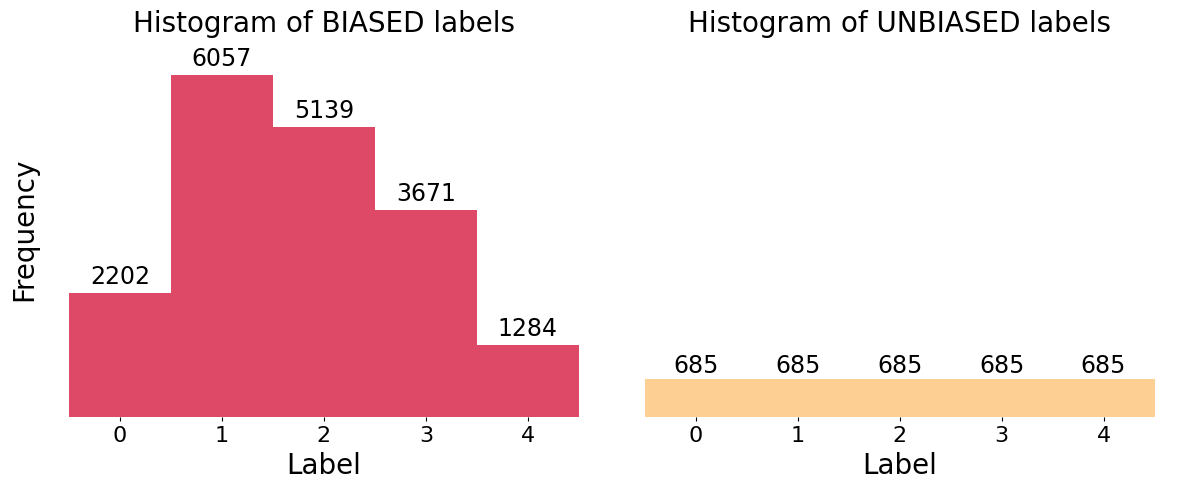

In [10]:
# Plot histograms in the same figure with two panels
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot histogram for bias_y
counts1, bins1, patches1 = ax1.hist(bias_y, bins=np.arange(6) - 0.5, color=col1)
ax1.set_xlabel('Label')
ax1.set_ylabel('Frequency')
ax1.set_title('Histogram of BIASED labels')
ax1.set_xticks(range(5))
ax1.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True, length=3)

# Add text on each bin for bias_y
for i, count in enumerate(counts1):
    if count > 0:
        ax1.text(i, count + max(counts1) * 0.01, str(int(count)), ha='center', va='bottom', fontsize=17)

# Plot histogram for unbias_y
counts2, bins2, patches2 = ax2.hist(unbias_y, bins=np.arange(6) - 0.5, color=col2)
ax2.set_xlabel('Label')
ax2.set_title('Histogram of UNBIASED labels')
ax2.set_xticks(range(5))
ax2.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True, length=3)

# Add text on each bin for unbias_y
for i, count in enumerate(counts2):
    if count > 0:
        ax2.text(i, count + max(counts2) * 0.01, str(int(count)), ha='center', va='bottom', fontsize=17)

# Set the same y-limits for both plots
max_count = max(max(counts1), max(counts2))
ax1.set_ylim(0, max_count * 1.1)
ax2.set_ylim(0, max_count * 1.1)

plt.tight_layout()
plt.show()



In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from tqdm import tqdm

class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 1024),
            nn.SiLU(),
            nn.Linear(1024, 512),
            nn.SiLU(),
            nn.Linear(512, 256),
            nn.SiLU(),
        )
        self.fc_mu = nn.Linear(256, 10)
        self.fc_logvar = nn.Linear(256, 10)
        self.decoder = nn.Sequential(
            nn.Linear(10, 256),
            nn.SiLU(),
            nn.Linear(256, 512),
            nn.SiLU(),
            nn.Linear(512, 1024),
            nn.SiLU(),
            nn.Linear(1024, 28*28),
            nn.Sigmoid(),
        )

    def encode(self, x):
        h = self.encoder(x)
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        return self.decoder(z).view(-1, 1, 28, 28)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

def loss_fn(recon_x, x, mu, logvar):
    BCE = nn.functional.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

batch_size = 128
bias_norm = bias.float().unsqueeze(1) / 255.
full_dataset = TensorDataset(bias_norm)

train_len = int(0.9 * len(full_dataset))
val_len = len(full_dataset) - train_len
train_set, val_set = random_split(full_dataset, [train_len, val_len])

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)

device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

vae = VAE().to(device)
optimizer = optim.Adam(vae.parameters(), lr=1e-3)

best_val_loss = float('inf')
patience = 5
patience_counter = 0
epochs = 100

epoch_iter = tqdm(range(epochs), desc="Training")
for epoch in epoch_iter:
    vae.train()
    train_loss = 0
    for batch in train_loader:
        x = batch[0].to(device)
        optimizer.zero_grad()
        recon_x, mu, logvar = vae(x)
        loss = loss_fn(recon_x, x, mu, logvar)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    vae.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in val_loader:
            x = batch[0].to(device)
            recon_x, mu, logvar = vae(x)
            loss = loss_fn(recon_x, x, mu, logvar)
            val_loss += loss.item()

    epoch_iter.set_postfix(train_loss=train_loss / len(train_loader.dataset),
                           val_loss=val_loss / len(val_loader.dataset))

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_state = vae.state_dict()
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            break

vae.load_state_dict(best_state)
vae.to('cpu')


Training:  38%|███▊      | 38/100 [00:13<00:22,  2.78it/s, train_loss=92.8, val_loss=99.7]


VAE(
  (encoder): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=1024, bias=True)
    (2): SiLU()
    (3): Linear(in_features=1024, out_features=512, bias=True)
    (4): SiLU()
    (5): Linear(in_features=512, out_features=256, bias=True)
    (6): SiLU()
  )
  (fc_mu): Linear(in_features=256, out_features=10, bias=True)
  (fc_logvar): Linear(in_features=256, out_features=10, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=10, out_features=256, bias=True)
    (1): SiLU()
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): SiLU()
    (4): Linear(in_features=512, out_features=1024, bias=True)
    (5): SiLU()
    (6): Linear(in_features=1024, out_features=784, bias=True)
    (7): Sigmoid()
  )
)

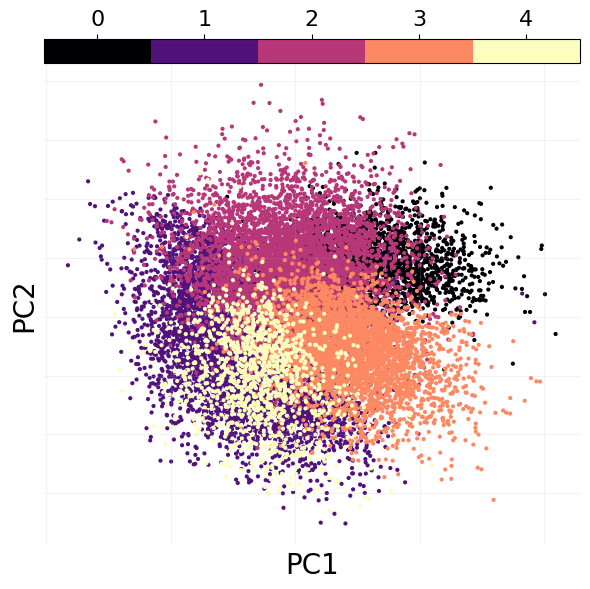

In [12]:
from torch.utils.data import DataLoader, TensorDataset

vae.to(device).eval()

dataset = TensorDataset(bias.float().unsqueeze(1) / 255., bias_y)
loader = DataLoader(dataset, batch_size=512, shuffle=False)

latents, labels = [], []
with torch.no_grad():
    for x, y in loader:
        mu, _ = vae.encode(x.to(device))
        latents.append(mu.cpu())
        labels.append(y)

z = torch.cat(latents).numpy()
lbl = torch.cat(labels).numpy()

# PCA for visualization
pca = PCA(n_components=2)
z_pca = pca.fit_transform(z)

unique_labels = np.unique(lbl)
n_classes = len(unique_labels)
discrete_magma = mcolors.ListedColormap(plt.cm.magma(np.linspace(0, 1, n_classes)), name='magma_discrete')
boundaries = np.arange(n_classes + 1) - 0.5
norm = mcolors.BoundaryNorm(boundaries, n_classes)

fig, ax = plt.subplots(figsize=(6, 6))
sc = ax.scatter(z_pca[:, 0], z_pca[:, 1], c=lbl, s=4, cmap=discrete_magma, norm=norm)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.grid(True, alpha=0.15)

from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(ax)
cax = divider.append_axes("top", size="5%", pad=0)
cbar = fig.colorbar(sc, cax=cax, boundaries=boundaries, orientation='horizontal')
cbar.ax.xaxis.set_ticks_position('top')
cbar.ax.xaxis.set_label_position('top')
cbar.set_ticks(unique_labels)
cbar.ax.minorticks_off()

fig.tight_layout()
plt.show()


/tmp/ipykernel_3758121/2612374891.py:21: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


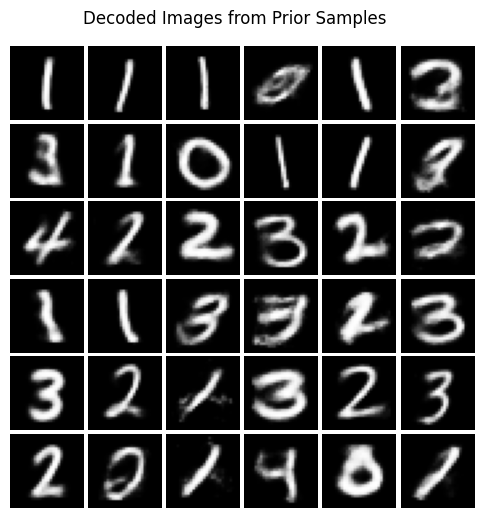

In [13]:
# Sample from the prior and decode to generate images
n_samples = 36
z_samples = torch.randn(n_samples, 10).to(device)  # Sample from standard normal prior

# Decode the samples
with torch.no_grad():
    generated_images = vae.decode(z_samples).cpu()

# Reshape images back to 28x28
generated_images = generated_images.view(n_samples, 28, 28)

# Plot in 6x6 grid
fig, axes = plt.subplots(6, 6, figsize=(6, 6), gridspec_kw={'wspace': 0.05, 'hspace': 0.05})
for i in range(6):
    for j in range(6):
        idx = i * 6 + j
        axes[i, j].imshow(generated_images[idx], cmap='gray')
        axes[i, j].axis('off')

plt.suptitle('Decoded Images from Prior Samples', y=0.94)
plt.tight_layout()
plt.show()


 ## Train an EBM on the latent space

In [14]:
vae.to(device).eval()

unbias_dataset = TensorDataset(unbias.float().unsqueeze(1) / 255., unbias_y)
unbias_loader = DataLoader(unbias_dataset, batch_size=512, shuffle=False)

latents_unbias, images_unbias, labels_unbias = [], [], []
with torch.no_grad():
    for x, y in unbias_loader:
        mu, _ = vae.encode(x.to(device))
        latents_unbias.append(mu.cpu())
        images_unbias.append(x.cpu())
        labels_unbias.append(y.cpu())

latents_unbias = torch.cat(latents_unbias)
images_unbias = torch.cat(images_unbias)
labels_unbias = torch.cat(labels_unbias)

unbias_tensor_dataset = TensorDataset(latents_unbias, images_unbias, labels_unbias)

train_len = int(0.9 * len(unbias_tensor_dataset))
val_len = len(unbias_tensor_dataset) - train_len
train_ebm_set, val_ebm_set = random_split(unbias_tensor_dataset, [train_len, val_len])

train_ebm_loader = DataLoader(train_ebm_set, batch_size=128, shuffle=True)
val_ebm_loader = DataLoader(val_ebm_set, batch_size=128, shuffle=False)


In [15]:
###### Energy-Based Model Implementation ######
class SmallEBM(nn.Module):
    def __init__(self, input_dim=10, hidden_dim=256):
        super(SmallEBM, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, 1),
        )

    def forward(self, x):
        return self.net(x).squeeze()

    def energy(self, x):
        return self.forward(x)


In [16]:
###### Energy-Based Model Training on Unbiased Latents ######
from tqdm import trange

ebm_epochs = 50
ebm = SmallEBM().to(device)
ebm_optimizer = optim.Adam(ebm.parameters(), lr=1e-3)

pbar = trange(ebm_epochs, desc="EBM Training")
for epoch in pbar:
    for latents, _, _ in train_ebm_loader:          # (z, x, y)
        batch = latents.to(device)

        # Positive energy
        pos_energy = ebm.energy(batch)

        # Negative samples ~ N(0, I)
        neg_samples = torch.randn_like(batch).to(device)
        neg_energy = ebm.energy(neg_samples)

        # Contrastive term
        loss = pos_energy.mean() - neg_energy.mean()

        # Energy norm regularization
        reg_loss = (pos_energy**2).mean() + (neg_energy**2).mean()

        # Gradient regularization
        interp = torch.rand(batch.size(0), 1, device=device)
        x_interp = (interp * batch + (1 - interp) * neg_samples).requires_grad_(True)
        energy_interp = ebm.energy(x_interp).mean()
        grad_interp = torch.autograd.grad(energy_interp, x_interp, create_graph=True)[0]
        grad_reg_loss = grad_interp.norm(2, dim=1).mean()

        # Total loss
        total_loss = loss + 0.1 * reg_loss + 0.1 * grad_reg_loss

        ebm_optimizer.zero_grad()
        total_loss.backward()
        ebm_optimizer.step()

    pbar.set_postfix(loss=total_loss.item(),
                     pos_energy=pos_energy.mean().item(),
                     neg_energy=neg_energy.mean().item())



EBM Training: 100%|██████████| 50/50 [00:03<00:00, 13.42it/s, loss=-4.95, neg_energy=4.94, pos_energy=-4.88] 


In [17]:
###### Energy-weighted sampling from the standard normal prior ######
n_prior = 1000
with torch.no_grad():
    prior_samples = torch.randn(n_prior, 10).to(device)
    energies = ebm.energy(prior_samples)             # shape (n_prior,)
    weights = torch.softmax(-energies, dim=0)        # Boltzmann weights
    index_samples = torch.distributions.Categorical(weights).sample((1000,))
    ew_priors = prior_samples[index_samples]



/tmp/ipykernel_3758121/1551108740.py:11: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


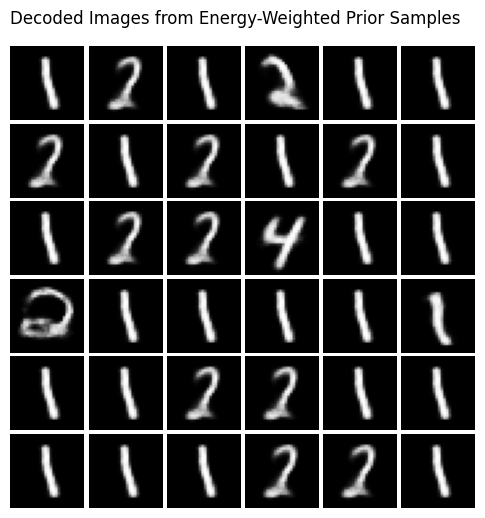

In [18]:
with torch.no_grad():
    decoded = vae.decode(ew_priors.to(device)).cpu().view(-1, 28, 28)

fig, axes = plt.subplots(6, 6, figsize=(6, 6), gridspec_kw={'wspace': 0.05, 'hspace': 0.05})
for i in range(6):
    for j in range(6):
        axes[i, j].imshow(decoded[i * 6 + j], cmap='gray')
        axes[i, j].axis('off')

plt.suptitle('Decoded Images from Energy-Weighted Prior Samples', y=0.94)
plt.tight_layout()
plt.show()


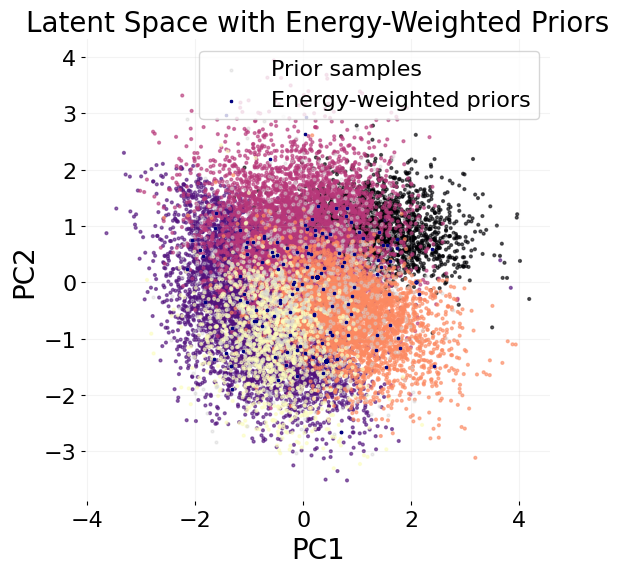

In [19]:
plt.figure(figsize=(6, 6))
# Transform for plotting
prior_pca = pca.transform(prior_samples.cpu().numpy())
ew_pca = pca.transform(ew_priors.cpu().numpy())
plt.scatter(z_pca[:, 0], z_pca[:, 1], c=lbl, s=4, alpha=0.6)
plt.scatter(prior_pca[:, 0], prior_pca[:, 1], c='lightgray', s=4, alpha=0.4, label='Prior samples')
plt.scatter(ew_pca[:, 0], ew_pca[:, 1], c='navy', s=3, marker='x', label='Energy-weighted priors')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Latent Space with Energy-Weighted Priors')
plt.legend()
plt.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True, length=3)
plt.tick_params(axis='y', which='both', left=True, right=False, labelleft=True, length=3)
plt.grid(True, alpha=0.15)
plt.show()


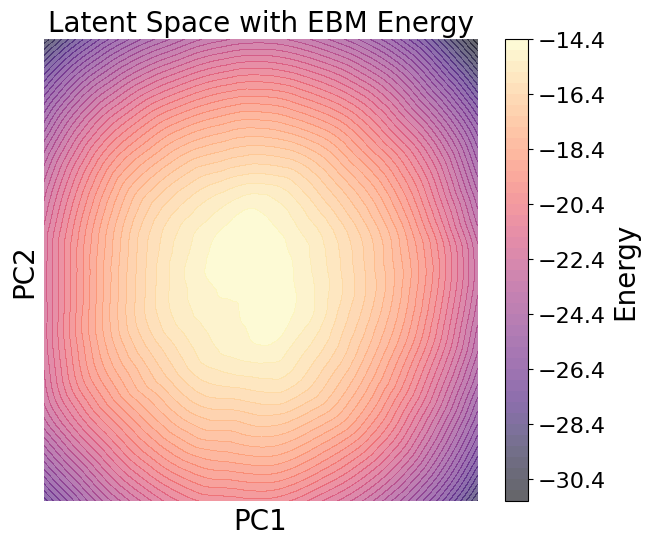

In [20]:
grid_res = 200
x_min, x_max = z_pca[:, 0].min() - 0.1, z_pca[:, 0].max() + 0.1
y_min, y_max = z_pca[:, 1].min() - 0.1, z_pca[:, 1].max() + 0.1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, grid_res),
                     np.linspace(y_min, y_max, grid_res))
grid_pca = np.vstack([xx.ravel(), yy.ravel()]).T
grid_latent = torch.from_numpy(pca.inverse_transform(grid_pca)).to(device).float()
with torch.no_grad():
    energy_vals = ebm.energy(grid_latent) + torch.distributions.Normal(0, 1).log_prob(grid_latent).sum(dim=1)
energy_grid = energy_vals.cpu().view(grid_res, grid_res)
plt.figure(figsize=(7, 6))
contour = plt.contourf(xx, yy, energy_grid.numpy(), levels=50, cmap='magma', alpha=0.6)
plt.colorbar(contour, label='Energy')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Latent Space with EBM Energy')
plt.show()
